In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker
import warnings

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=6)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.57:37503 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.57:37503,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import sectionate
print(f"Sectionate version: {sectionate.__version__}")

Sectionate version: 0.2.1


In [6]:
from Streamfunctions import *
from Streamfunctions_Sectionate import *

rho0 = 1035. # kg/m3
Sv_s_per_m3 = 1e-6
Sv_s_per_kg = Sv_s_per_m3/rho0

In [7]:
get_transports = lambda ds: ds[["umo", "vmo", "thkcello", "sigma2_i", "zos"]]
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        preprocess = get_transports, 
        engine="zarr")
ds = ds.fillna(0.0)
ds = ds.mean("time", skipna = True).compute()
ds_transport_snapshot = get_transports(ds).compute()

In [8]:
grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")

In [9]:
ds["z"] = approximate_z_top_down(ds)

In [10]:
div_v = grid.diff(grid._ds["vmo"], axis = "Y", boundary = "fill").fillna(0.0)
div_v = div_v.compute() #calculate meridional divergence, can be used to calculate northwayrd transport

geolat = ds.geolat.compute()
grid._ds["geolat_v"] = grid._ds["geolat_v"].compute()
grid._ds["geolat"] = grid._ds["geolat"].compute()

lats = np.arange(35, 51, 1)

reverse_sigma2 = lambda ds: ds.isel({"sigma2_l": slice(None, None, -1)})

psi_lats_list = []
mean_thk_list = []
mean_depth_list = []
mean_zos_list = []

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=UserWarning)
    for lat in lats: 

        psi_lat = (div_v * (geolat >= lat))
        psi_lat = psi_lat.where(psi_lat != 0).sum(["xh", "yh"], skipna = True)
        diff_lat_mask = np.abs(grid.diff(1. * (grid._ds["geolat_v"]>= lat), axis = "Y"))
        diff_lat_mask = diff_lat_mask.where(diff_lat_mask > 0)

        mean_depth = (ds["z"] * diff_lat_mask)
        mean_depth = mean_depth.where((diff_lat_mask > 0) * (ds["thkcello"] > 0)).mean(["xh", "yh"], skipna = True)
        mean_depth_list += [mean_depth.compute().assign_coords(lat=lat)]

        psi_lat = (psi_lat.cumsum('sigma2_l') - psi_lat.sum('sigma2_l'))
        psi_lat = psi_lat.assign_coords(lat=lat)  # single float value
    
        psi_lats_list += [psi_lat]
        if (lat % 5) == 0: 
            print(lat)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


35
40
45
50


In [11]:
psi_try = xr.concat(psi_lats_list, dim = "lat").sortby("lat") 
depth_try = xr.concat(mean_depth_list, dim = "lat").sortby("lat")

psi_try_ds = -psi_try.rename("psi").to_dataset()* Sv_s_per_kg
psi_try_ds["sigma2_i"] = ds["sigma2_i"]
psi_try_ds["z"] = depth_try
psi_try_ds

psi_grid = Grid(psi_try_ds, coords={'Z': {'center':'sigma2_l'}}, periodic=False, autoparse_metadata = False)

# # define the target values in density, linearly spaced
z_target = np.linspace(-7000, 51, 50)

# # and transform
psi_transformed = psi_grid.transform(psi_try_ds.psi, 'Z', z_target, target_data=psi_try_ds["z"], method = "linear", bypass_checks = False)


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


In [12]:
from scipy import interpolate
def interp_column(var_1d, depth_1d, new_z):
    # 1) mask invalid
    mask = np.isfinite(depth_1d)
    if mask.sum() < 2:
        return np.full(new_z.shape, np.nan)
    d = depth_1d[mask]
    v = var_1d[mask]
    # 2) let scipy sort & interpolate
    f = interp1d(
        d, v,
        kind='linear',
        bounds_error=False,
        fill_value=np.nan,
        assume_sorted=False   # ← scipy will sort d & v internally
    )
    return f(new_z)

# apply function over every (y,x) column
psi_z = xr.apply_ufunc(
    interp_column,
    psi_try_ds['psi'], psi_try_ds['z'],
    input_core_dims=[['sigma2_l'], ['sigma2_l']],
    output_core_dims=[['Z']],
    vectorize=True,
    kwargs={'new_z': z_target},
    dask='parallelized',
    output_dtypes=[psi_try_ds['psi'].dtype]
)

# finally assign the new coordinate name
psi_z = psi_z.assign_coords(Z=z_target)

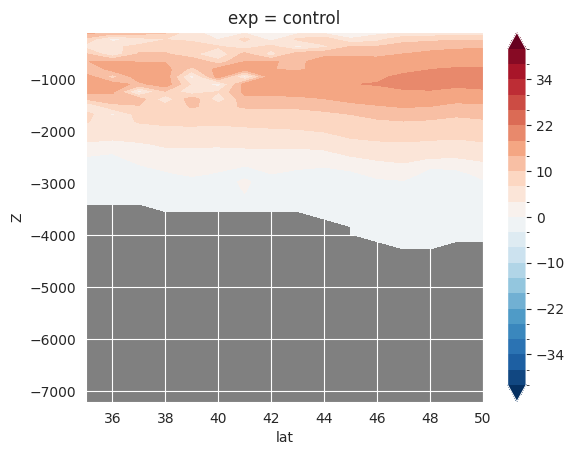

In [13]:
levels = np.arange(-42, 42.1, 4)
levels = np.sort(np.concatenate([levels, [0]])[:])
psi_transformed = psi_transformed.where(np.abs(psi_transformed) > 1e-6)

psi_z.isel(exp = 1).T.plot.contourf(levels = levels, extend = "both")
plt.gca().set_facecolor("grey")
plt.gca().set_ylim(-7200, -100)
plt.savefig("Control_streamfunction.png", dpi = 200)

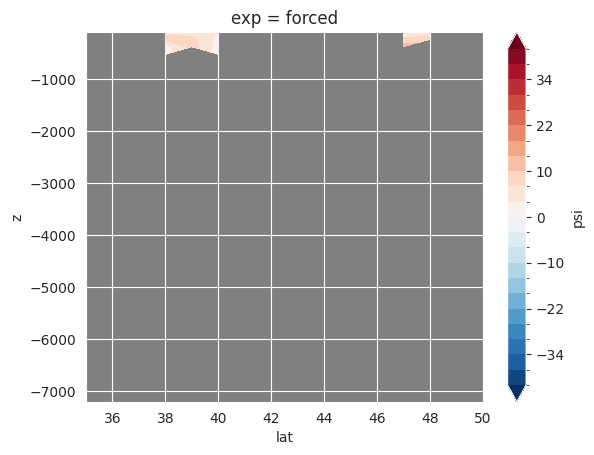

In [14]:
levels = np.arange(-42, 42.1, 4)
levels = np.sort(np.concatenate([levels, [0]])[:])
# psi_transformed = psi_transformed.where(np.abs(psi_transformed) > 1e-6)

psi_transformed.isel(exp = 0).T.plot.contourf(levels = levels, extend = "both")
plt.gca().set_facecolor("grey")
plt.gca().set_ylim(-7200, -100)
plt.savefig("Control_streamfunction.png", dpi = 200)